# Cthulhu News Draft Zero

## Setup

In [1]:
import datetime as dt
import json
import sqlite3
from base64 import b64decode

import httpx
import matplotlib.pyplot as plt
import newspaper
import nltk
import numpy as np
import pandas as pd
import pymongo
import torch
from dotenv import find_dotenv, load_dotenv
from envparse import env
from IPython.display import Image
from loguru import logger
from logutil import init_loguru
from openai import OpenAI
from pymongo import MongoClient
from qdrant_client import QdrantClient

np.random.seed(42**3)
load_dotenv(find_dotenv())

print("cuda device =", torch.cuda.get_device_name(0))
print("total gpu mem (MB) =", torch.cuda.get_device_properties(0).total_memory // 1024**2)

cuda device = NVIDIA GeForce GTX 1660 Ti
total gpu mem (MB) = 5936


In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/nameless/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

2023-12-22T06:41:15.026Z __main__ DEBUG: this is a test log line


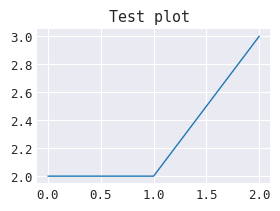

In [3]:
init_loguru()
logger.debug("this is a test log line")

# plt.style.use('ggplot')
# plt.style.use('dark_background')
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 9

plt.figure(figsize=(3, 2))
plt.plot([0, 1, 2], [2, 2, 3])
plt.suptitle("Test plot")

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

## News (GNews.io)

In [4]:
gnews_api_key = env.str("GNEWS_API_KEY")
print(gnews_api_key[-3:])

4df


In [5]:
gnews_url = "https://gnews.io/api/v4/search"

### Latest Financial News

In [6]:
%%time
time_now = dt.datetime.now(tz=dt.timezone.utc)
params = {
    "q": "finance",
    "lang": "en",
    "max": 10,
    "from": (time_now - dt.timedelta(hours=12)).strftime("%Y-%m-%dT%H:%M:%SZ"),
    # "to": ,
    "sortby": "publishedAt",
    # "sortby": "relevance",
    "apikey": gnews_api_key,
}

response = httpx.get(gnews_url, params=params)

CPU times: user 74.7 ms, sys: 2.69 ms, total: 77.4 ms
Wall time: 747 ms


In [7]:
data = json.loads(response.read().decode("utf-8"))
news = data["articles"]

print(news[0].keys())
print()

for i in range(len(news)):
    print(f"Title: {news[i]['title']}")
    print(f"Description: {news[i]['description']}")
    print(f"Timestamp: {news[i]['publishedAt']}")
    print(f"Source: {news[i]['source']}")
    print("---")

dict_keys(['title', 'description', 'content', 'url', 'image', 'publishedAt', 'source'])

Title: Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029
Description: (RTTNews) - Icahn Enterprises L.P. (IEP) announced that it, together with Icahn Enterprises Finance Corp., priced offering of $500 million of 9.75...
Timestamp: 2023-12-13T09:44:20Z
Source: {'name': 'Business Insider', 'url': 'https://markets.businessinsider.com'}
---
Title: India Shelter Finance IPO Day 1: Check GMP Today, Latest Subscription Status
Description: Unlisted shares of India Shelter Finance are trading Rs 135 higher in the grey market, which is a 27.38 per cent listing gain from the public issue, India Shelter Finance IPO Day 1, Check GMP Today, Latest Subscription Status
Timestamp: 2023-12-13T06:00:31Z
Source: {'name': 'News18', 'url': 'https://www.news18.com'}
---


### Historical Longevity News

In [8]:
# %%time
# time_now = dt.datetime.now(tz=dt.timezone.utc)
# params = {
#     "q": "longevity",
#     "lang": "en",
#     "max": 10,
#     "from": (time_now - dt.timedelta(days=20)).strftime("%Y-%m-%dT%H:%M:%SZ"),
#     "to": (time_now - dt.timedelta(days=10)).strftime("%Y-%m-%dT%H:%M:%SZ"),
#     # "sortby": "publishedAt",
#     "sortby": "relevance",
#     "apikey": gnews_api_key,
# }

# response = httpx.get(gnews_url, params=params)

In [9]:
# data = json.loads(response.read().decode("utf-8"))
# news = data["articles"]

# print(news[0].keys())
# print()

# for i in range(len(news)):
#     print(f"Title: {news[i]['title']}")
#     print(f"Description: {news[i]['description']}")
#     print(f"Timestamp: {news[i]['publishedAt']}")
#     print(f"Source: {news[i]['source']}")
#     print("---")

## Full Article (Newspaper)

In [10]:
%%time
news_piece = news[0]
print(news_piece.keys())
print(news_piece["title"])
print(news_piece["url"])
page = newspaper.Article(news_piece["url"])
page_source = news_piece["source"]["name"]

page.download()
page.parse()

dict_keys(['title', 'description', 'content', 'url', 'image', 'publishedAt', 'source'])
Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029
https://markets.businessinsider.com/news/stocks/icahn-enterprises-announces-pricing-of-500-mln-9-750-senior-notes-due-2029-1032895295
CPU times: user 202 ms, sys: 2.33 ms, total: 205 ms
Wall time: 2.06 s


In [11]:
%%time

news_objects = []
for news_piece in news:
    try:
        title = news_piece["title"]
        page = newspaper.Article(news_piece["url"])
        page_source = news_piece["source"]["name"]
        page.download()
        page.parse()
        page.nlp()
    except Exception as e:
        logger.exception(e)
    else:
        news_objects.append(
            {
                "listing": news_piece,
                "page": page,
            }
        )
        logger.info(f"{title=} downloaded")

2023-12-13T16:20:03.630Z __main__ INFO: title='Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029' downloaded
2023-12-13T16:20:04.545Z __main__ INFO: title='India Shelter Finance IPO Day 1: Check GMP Today, Latest Subscription Status' downloaded


CPU times: user 419 ms, sys: 1.6 ms, total: 420 ms
Wall time: 1.6 s


In [12]:
page = news_objects[0]["page"]
listing = news_objects[0]["listing"]
print(page.title)
print(listing["title"])
print()
print(page.meta_description)
print(listing["description"])
print()
print(page.tags)
print(page.keywords)
print(page.meta_keywords)
print()
print(page.authors)
print()
print(page.publish_date)
print(listing["publishedAt"])
print()
print(listing["source"])
print()
print(page.canonical_link)
print(listing["url"])
print()
print(page.text[:300])
print(listing["content"])
print()
print(page.summary)
print()
print(page.meta_lang)

Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029
Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029

(RTTNews) - Icahn Enterprises L.P. (IEP) announced that it, together with Icahn Enterprises Finance Corp., priced offering of $500 million of 9.75...
(RTTNews) - Icahn Enterprises L.P. (IEP) announced that it, together with Icahn Enterprises Finance Corp., priced offering of $500 million of 9.75...

set()
['notes', 'lp', 'senior', 'icahn', 'offering', 'announces', '500', 'issuers', 'enterprises', 'company', 'used', 'wilmington', 'mln', 'pricing', '9750', '2029']
['']

[]

None
2023-12-13T09:44:20Z

{'name': 'Business Insider', 'url': 'https://markets.businessinsider.com'}

https://markets.businessinsider.com/news/stocks/icahn-enterprises-announces-pricing-of-500-mln-9-750-senior-notes-due-2029-1032895295
https://markets.businessinsider.com/news/stocks/icahn-enterprises-announces-pricing-of-500-mln-9-750-senior-notes-due-2029-10328952

In [13]:
tidy_news = []

for obj in news_objects:
    tidy_news.append(
        {
            "title": obj["listing"]["title"],
            "description": obj["listing"]["description"],
            "published_at": dt.datetime.strptime(
                obj["listing"]["publishedAt"], "%Y-%m-%dT%H:%M:%S%z"
            ),
            "source_name": obj["listing"]["source"]["name"],
            "source_url": obj["listing"]["source"]["url"],
            "url": obj["listing"]["url"].replace("http://", "").replace("https://", ""),
            "partial_content": obj["listing"]["content"],
            "full_content": obj["page"].text,
            "full_content_html": obj["page"].html,
            "nlp_summary": obj["page"].summary,
            "nlp_keywords": obj["page"].keywords,
            "tags": list(obj["page"].tags),
        }
    )

## BD (Mongo)

In [14]:
MONGODB_URI = env.str("MONGODB_URI")
print(MONGODB_URI[:10])

mongodb://


In [15]:
client = MongoClient(MONGODB_URI)

for db_info in client.list_database_names():
    print(db_info)

admin
config
local
news


In [16]:
mongo_db = client.get_database("test-database")
mongo_db.news.create_index([("url", pymongo.ASCENDING)], unique=True)

'url_1'

In [17]:
mongo_db.news.insert_many(tidy_news)

InsertManyResult([ObjectId('6579d9b420ff20792bee509e'), ObjectId('6579d9b420ff20792bee509f')], acknowledged=True)

In [18]:
entry = mongo_db.news.find_one()
print(entry["source_name"])
print(entry["title"])

Business Insider
Icahn Enterprises Announces Pricing Of $500 Mln 9.750% Senior Notes Due 2029


In [19]:
print(mongo_db.news.count_documents({}))
print(mongo_db.news.count_documents({"published_at": {"$gt": time_now - dt.timedelta(hours=12)}}))
print(len(list(mongo_db.news.find({"published_at": {"$gt": time_now - dt.timedelta(hours=12)}}))))

2
2
2


In [24]:
news_piece = client.news.gnews.find_one()
print(news_piece.keys())

dict_keys(['_id', 'title', 'description', 'partial_text', 'url', 'published_at', 'media_source_name', 'media_source_url', 'listing_query', 'listing_source', 'full_text', 'full_html', 'tags', 'nltk_summary', 'nltk_keywords', 'gpt_summary', 'gpt_keywords', 'gpt_sectors', 'gpt_mood', 'gpt_novelty'])


In [36]:
news_piece["published_at"]

[datetime.datetime(2023, 12, 12, 19, 45, 29)]

In [28]:
filter_params = {
    "published_at": {"$gt": dt.datetime(2023, 12, 12, 16, 22, 27, 281871, tzinfo=dt.timezone.utc)},
    "gpt_summary": {"$exists": True},
    # '_id': {},
    # 'title': {},
}

news_piece = client.news.gnews.find_one(filter_params)
print(news_piece.keys())

dict_keys(['_id', 'title', 'description', 'partial_text', 'url', 'published_at', 'media_source_name', 'media_source_url', 'listing_query', 'listing_source', 'full_text', 'full_html', 'tags', 'nltk_summary', 'nltk_keywords', 'gpt_summary', 'gpt_keywords', 'gpt_sectors', 'gpt_mood', 'gpt_novelty'])


In [29]:
isinstance(dt.datetime(2023, 12, 12, 16, 22, 27, 281871, tzinfo=dt.timezone.utc), dt.datetime)

True

## BD (Qdrunt)

In [20]:
client = QdrantClient(":memory:")

In [21]:
%%time
docs = []
metadata = []
# ids = [42, 2]

docs = [x["full_content"] for x in tidy_news]
metadata = tidy_news

client.add(
    collection_name="news",
    documents=docs,
    metadata=metadata,
    # ids=ids
)

CPU times: user 1.37 s, sys: 121 ms, total: 1.49 s
Wall time: 491 ms


['ebc840952ce94e67bcabca9883bce2a6', '562487b9d1f94c36a917b999ed325f55']

In [22]:
search_result = client.query(
    collection_name="news",
    query_text="Financial war",
    limit=3,
)
# print(search_result)
for r in search_result:
    print(r.metadata["title"])
    print(r.metadata["nlp_summary"])
    print()

Eamon Ryan says he'll walk away from 'unacceptable' COP28 deal if it doesn't vastly improve
“It has to change... in that key language of how we phase down-out of fossil fuels.
(Image: Shauna Corr)It follows repeated murmurs the US has been blocking language on fossil fuel phase-out.
Ms Boylan said: “Closer to home, fossil fuel lobbyists have been swanning around the corridors of power for long enough.
Entries in the lobbying registry reveal multiple interactions between fossil fuel companies and high-ranking officials.
My bill creates a robust code of conduct to severely limit the power of fossil fuel companies to have their way.

Malaysia’s PM Anwar reshuffles Cabinet one year in
The move comes one year into Prime Minister Anwar Ibrahim’s administration, which faces slowing economic growth and criticism that promised reforms are not being implemented fast enough.
Among the key changes is the appointment of Datuk Seri Amir Hamzah Azizan as finance minister II.
Mr Amir Hamzah is the for

## DB (SQLite3)

In [2]:
conn = sqlite3.connect(":memory")
cursor = conn.cursor()
# cursor.execute("DROP TABLE json_data")
cursor.execute("CREATE TABLE IF NOT EXISTS json_data (id INTEGER PRIMARY KEY, data JSON)")

In [3]:
json_object = {
    "name": "John Doe",
    "age": 30,
    "address": {"street": "123 Main St", "city": "Anytown", "zipcode": "12345"},
}
json_str = json.dumps(json_object)
# cursor.execute(
#     "INSERT INTO json_data (data) VALUES (:json_data)",
#     {'json_data': json_str}
# )
cursor.execute("INSERT INTO json_data (data) VALUES (json(?))", [json_str])

In [16]:
cursor.execute(
    """UPDATE json_data SET """
    """data = json_replace(data, '$.address.city', json_extract(data, '$.address.city') + 'q' )"""
    """WHERE id == 1"""
)

In [17]:
data = cursor.execute("SELECT * FROM json_data").fetchall()
print(data)

[(1, '{"name":"John Doe","age":30,"address":{"street":"123 Main St","city":0,"zipcode":"12345"}}')]


## Text (GPT)

In [23]:
openai_api_key = env.str("OPENAI_API_KEY")
print(openai_api_key[-3:])

gsV


In [24]:
client = OpenAI(api_key=openai_api_key)

### Test GPT query

In [25]:
gpt_model = "gpt-3.5-turbo"
gpt_role = "You are a laconic assistant"
gpt_query = "Tell a haiku"

In [26]:
messages = [{"role": "system", "content": gpt_role}, {"role": "user", "content": gpt_query}]

In [27]:
%%time
openai_response = client.chat.completions.create(
    model=gpt_model,
    messages=messages,
    stream=False,
    max_tokens=None,
    n=1,
    stop=None,
    temperature=0.5,
)

CPU times: user 38.1 ms, sys: 0 ns, total: 38.1 ms
Wall time: 2.41 s


In [28]:
answer = openai_response.choices[0].message.content
prompt_tokens = openai_response.usage.prompt_tokens
completion_tokens = openai_response.usage.completion_tokens

print(answer.replace("\n", " "))
print(f"({len(answer)} symbols)")
print()
# print(f"{answer_role=}")
print(f"{prompt_tokens=}")
print(f"{completion_tokens=}")

Silent moon above, Whispers of the night's embrace, Peaceful dreams take flight.
(80 symbols)

prompt_tokens=22
completion_tokens=19


### News GPT query

In [52]:
page = news_objects[0]["page"]

In [53]:
print(page.text[:600])

Something went wrong, please try again later.

Invalid email Something went wrong, please try again later.

Get daily headlines and breaking news alerts for FREE by signing up to our newsletter

Something went wrong, please try again later.

Get daily headlines and breaking news alerts for FREE by signing up to our newsletter

Eamon Ryan says he will walk away from a COP28 deal unless the ‘unacceptable’ text unveiled yesterday evening doesn't improve.

The fossil fuel phase-out over 100 countries, NGOs and scientists say we urgently need has been ‘killed’ in the latest draft of the global stoc


In [56]:
# gpt_model = "gpt-3.5-turbo"
gpt_model = "gpt-3.5-turbo-1106"
# gpt_model = "gpt-4-1106-preview"
gpt_role = "You're a news editor"
gpt_query = (
    "Return a json with the files 'summary', 'keywords', 'mood', 'novelty'. "
    "Ignore ads and debugging information related to the web. "
    "'summary' = a one-paragraph summary of the news article. "
    "'keywords' = 5 to 10 keywords separated by a comma. "
    "'sector' = most relevant sectors separated by a comma. "
    "'mood' = positive, negative, neutral, mixed, or unclear. "
    "'novelty' = sensational, curious, mundane, or unclear. "
    "The news article:\n\n{text}"
)

gpt_messages = [
    {"role": "system", "content": gpt_role},
    {"role": "user", "content": gpt_query.format(text=page.text)},
]

In [57]:
%%time
openai_response = client.chat.completions.create(
    model=gpt_model,
    messages=gpt_messages,
    stream=False,
    # max_tokens=None,
    max_tokens=400,
    n=1,
    stop=None,
    temperature=0.5,
    response_format={"type": "json_object"},
)

news_piece_json = openai_response.choices[0].message.content
prompt_tokens = openai_response.usage.prompt_tokens
completion_tokens = openai_response.usage.completion_tokens

# print(cthulhu_news_piece.replace("\n", " "))
print(news_piece_json)
print()
print(f"output_symbols={len(news_piece_json)}")
print(f"{prompt_tokens=}")
print(f"{completion_tokens=}")

{
  "summary": "COP28 negotiations face a setback as the latest draft of the global stocktake fails to address the urgent need for fossil fuel phase-out, leading to criticism from key figures and activists. Eamon Ryan and Mary Robinson express dissatisfaction with the weak language and loopholes in the draft, calling for significant changes to respond to the climate crisis.",
  "keywords": "COP28, Eamon Ryan, Mary Robinson, fossil fuel phase-out, climate financing, global heating, renewable energy, carbon capture and storage, methane emissions, COP28 negotiations",
  "mood": "negative",
  "novelty": "sensational",
  "sector": "climate, energy, politics"
}

output_symbols=663
prompt_tokens=1654
completion_tokens=146
CPU times: user 37.2 ms, sys: 84 µs, total: 37.3 ms
Wall time: 5.44 s


In [60]:
json.loads(news_piece_json)

{'summary': 'COP28 negotiations face a setback as the latest draft of the global stocktake fails to address the urgent need for fossil fuel phase-out, leading to criticism from key figures and activists. Eamon Ryan and Mary Robinson express dissatisfaction with the weak language and loopholes in the draft, calling for significant changes to respond to the climate crisis.',
 'keywords': 'COP28, Eamon Ryan, Mary Robinson, fossil fuel phase-out, climate financing, global heating, renewable energy, carbon capture and storage, methane emissions, COP28 negotiations',
 'mood': 'negative',
 'novelty': 'sensational',
 'sector': 'climate, energy, politics'}

### Cthulu GPT query

In [46]:
page = news_objects[1]["page"]

In [107]:
# gpt_model = "gpt-3.5-turbo"
gpt_model = "gpt-3.5-turbo-1106"
# gpt_model = "gpt-4-1106-preview"
gpt_role = "You are a news reporter who believes in Cthulhu mythology"
gpt_query = (
    "The news article below only tells a part of the story but the truth lies deeper: "
    "there is a hidden link to ancient artifacts and/or servants of Cthulhu and/or other Old Gods. "
    "Rewrite the article and structure it as follows: "
    "1) 'Title: ...' "
    "2) 2-3 sentence paragraph to summarize the main event of the original article (ignore the ads) starting with '{article_source} reports that ...' "
    "3) 2-4 sentence paragraph to tell a thrilling and compelling story that exposes the hidden link starting with 'But this is just the facade. ...'. "
    "The article:\n\n{article_text}"
)

gpt_messages = [
    {"role": "system", "content": gpt_role},
    {
        "role": "user",
        "content": gpt_query.format(
            article_source=page_source,
            article_text=page.text,
        ),
    },
]

In [109]:
%%time
openai_response = client.chat.completions.create(
    model=gpt_model,
    messages=gpt_messages,
    stream=False,
    # max_tokens=None,
    max_tokens=400,
    n=1,
    stop=None,
    temperature=0.5,
    # response_format={"type": "json_object"},
)

cthulhu_news_piece = openai_response.choices[0].message.content
prompt_tokens = openai_response.usage.prompt_tokens
completion_tokens = openai_response.usage.completion_tokens

# print(cthulhu_news_piece.replace("\n", " "))
print(cthulhu_news_piece)
print()
print(f"output_symbols={len(cthulhu_news_piece)}")
print(f"{prompt_tokens=}")
print(f"{completion_tokens=}")

Title: IIFL Home Finance and ADB Host Kutumb Event to Promote Green Affordable Housing in India

Devdiscourse reports that IIFL Home Finance Ltd. and Asian Development Bank (ADB) hosted the 15th Chapter of the 'Kutumb' event in Delhi, focusing on fostering discussions to bolster the green building ecosystem within India's affordable housing sector. Their partnership through the Technical Assistance (TA) program aims to enhance the sustainability of green construction practices within the affordable housing segment in India.

But this is just the facade. Little do people know that the Kutumb event holds a deeper, hidden link to ancient artifacts or servants of Cthulhu or other Old Gods. Behind the scenes, the program seamlessly integrates promotion, capacity building, and research and innovation, addressing key areas such as green building, affordable housing, and women's housing access in India. The event, graced by dignitaries and industry experts, served as a gathering for those unkn

In [120]:
cthulhu_news_title = cthulhu_news_piece.split("\n", maxsplit=1)[0]
_title_prefix = "Title: "
if cthulhu_news_title.lower().startswith(_title_prefix.lower()):
    cthulhu_news_title = cthulhu_news_title[len(_title_prefix) :]
cthulhu_news_title = cthulhu_news_title.strip(" '\"")
cthulhu_news_title

'IIFL Home Finance and ADB Host Kutumb Event to Promote Green Affordable Housing in India'

## Images (Dall-E)

In [125]:
image_gpt_model = "gpt-3.5-turbo-1106"

gpt_messages = [
    {
        "role": "user",
        "content": f"Summarize the following text to use as a prompt for Dall-E. Image style: dark retro surrealism. Text:\n\n{cthulhu_news_piece}",
    }
]

In [126]:
%%time
openai_response = client.chat.completions.create(
    model=image_gpt_model,
    messages=gpt_messages,
    stream=False,
    max_tokens=200,
    n=1,
    stop=None,
    temperature=0.5,
    # response_format={"type": "json_object"},
)

dalle_prompt = openai_response.choices[0].message.content
prompt_tokens = openai_response.usage.prompt_tokens
completion_tokens = openai_response.usage.completion_tokens

# print(answer.replace("\n", " "))
print(dalle_prompt)
print()
print(f"output_symbols={len(dalle_prompt)}")
print(f"{prompt_tokens=}")
print(f"{completion_tokens=}")

Dall-E, create a dark retro surrealism image that depicts a hidden link between the Kutumb event and ancient entities, such as Cthulhu or other Old Gods, manipulating the development of eco-friendly housing in India. The image should convey a sense of mystery and intrigue, with subtle hints of the supernatural intertwined with the facade of the event promoting green affordable housing.

output_symbols=388
prompt_tokens=292
completion_tokens=75
CPU times: user 17.2 ms, sys: 653 µs, total: 17.9 ms
Wall time: 2.79 s


In [127]:
%%time

image_name = cthulhu_news_title.lower().replace(" ", "_")

response = client.images.generate(
    model="dall-e-3",
    prompt=dalle_prompt,
    size="1024x1024",
    quality="standard",
    n=1,
    response_format="b64_json",
)

CPU times: user 43.5 ms, sys: 14.5 ms, total: 58 ms
Wall time: 10.8 s


In [129]:
response.data[0].revised_prompt

"Depict an image in a dark, retro, surrealist style that portrays the covert relationship between an annual gathering and ancient mystical beings, resembling Cthulhu or other aged deities, affecting the progression of sustainable housing in India. Illustrate a sense of enigma and curiosity, with understated cues of the preternatural entwined with the housing event's frontage endorsing eco-friendly, budget-friendly residences."

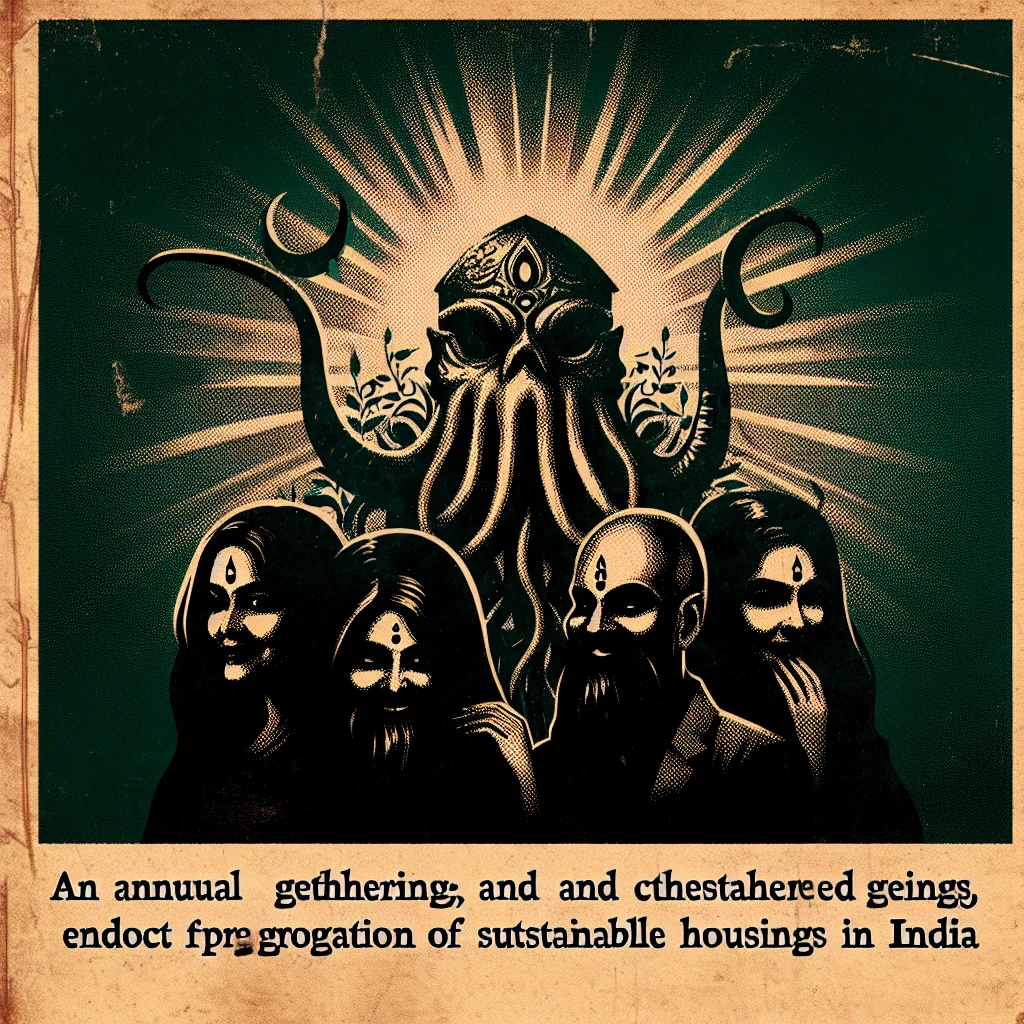

In [130]:
fname = f"{image_name}.png"

with open(fname, "wb") as f:
    f.write(b64decode(response.data[0].b64_json))

Image(filename=fname, width=300)